# Import sentiment data AMZN

In [4]:
# Import libraries
from urllib.request import urlopen, Request
import nltk
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.sentiment.vader import SentimentIntensityAnalyzer

web_archive = 'https://web.archive.org/web/'
finviz_URL = '/https://finviz.com/quote.ashx?t='


news_tables = {}
ticker = 'AMZN'
j=0

for index in archive_index:
    j = j+1
    print('Uploading file %f....' % j)
    print(len(news_tables))
    url = web_archive + str(index) + finviz_URL + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    html = BeautifulSoup(response)
    news_table = html.find(id='news-table')
    news_tables[j] = news_table


Uploading file 1.000000....
0
Uploading file 2.000000....
1
Uploading file 3.000000....
2
Uploading file 4.000000....
3
Uploading file 5.000000....
4
Uploading file 6.000000....
5
Uploading file 7.000000....
6
Uploading file 8.000000....
7
Uploading file 9.000000....
8
Uploading file 10.000000....
9
Uploading file 11.000000....
10
Uploading file 12.000000....
11
Uploading file 13.000000....
12
Uploading file 14.000000....
13
Uploading file 15.000000....
14
Uploading file 16.000000....
15
Uploading file 17.000000....
16
Uploading file 18.000000....
17
Uploading file 19.000000....
18
Uploading file 20.000000....
19
Uploading file 21.000000....
20
Uploading file 22.000000....
21
Uploading file 23.000000....
22
Uploading file 24.000000....
23
Uploading file 25.000000....
24
Uploading file 26.000000....
25
Uploading file 27.000000....
26
Uploading file 28.000000....
27
Uploading file 29.000000....
28
Uploading file 30.000000....
29
Uploading file 31.000000....
30
Uploading file 32.000000...

In [15]:
parsed_news_AMZN = []


for file_name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
        text = x.a.get_text() 
        date_scrape = x.td.text.split()
        if len(date_scrape) == 1:
            time = date_scrape[0] 
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        page_index = str(file_name)
        parsed_news_AMZN.append([page_index, date, time, text])
        
parsed_news_AMZN[1]

['1',
 'Nov-03-21',
 '03:19PM',
 'Biden, Kerry to tap Apple, Amazon and others for the tech to lower steel and trucking emissions']

In [16]:
#### Sentiment Analysis
vader = SentimentIntensityAnalyzer()


columns = ['page_index', 'date', 'time', 'headline']


parsed_and_scored_news_AMZN = pd.DataFrame(parsed_news_AMZN, columns=columns)


scores_AMZN = parsed_and_scored_news_AMZN['headline'].apply(vader.polarity_scores).tolist()


scores_df_AMZN = pd.DataFrame(scores_AMZN)


parsed_and_scored_news_AMZN = parsed_and_scored_news_AMZN.join(scores_df_AMZN, rsuffix='_right')


parsed_and_scored_news_AMZN['date'] = pd.to_datetime(parsed_and_scored_news_AMZN.date).dt.date
parsed_and_scored_news_AMZN.drop_duplicates('headline', inplace = True)
parsed_and_scored_news_AMZN.tail(30)



daily_count_AMZN = parsed_and_scored_news_AMZN.value_counts('date')
AMZNSentimentData = parsed_and_scored_news_AMZN.drop(['time'],axis=1).groupby('date').mean()
print(daily_count_AMZN)

AMZNSentimentData.set_index(pd.to_datetime(AMZNSentimentData.index, format = '%Y-%m-%d'),inplace=True)
AMZNSentimentData.sort_values(by='date', axis=0,ascending=False,inplace=True)
AMZNSentimentData = pd.concat((AMZNSentimentData,daily_count_AMZN), axis=1, join='inner')
AMZNSentimentData['references'] = AMZNSentimentData[0]
AMZNSentimentData.drop(0,axis=1,inplace=True)
AMZNSentimentData.index.min()

date
2021-06-21    48
2021-07-06    48
2021-04-15    45
2021-06-22    45
2021-04-30    43
              ..
2021-02-09     2
2021-02-02     2
2021-06-20     2
2021-06-30     1
2021-07-30     1
Length: 207, dtype: int64


datetime.date(2021, 1, 21)

In [17]:
import datetime
from datetime import date
from pandas_datareader.data import DataReader
from yahoofinancials import YahooFinancials
import numpy as np
import backtrader as bt
import talib
pd.options.mode.chained_assignment = None

In [18]:
### Import financial data

def yahooImport(ticker,start,end,period):
    yahoo_financials = YahooFinancials(ticker)
    data = pd.DataFrame(yahoo_financials.get_historical_price_data(start, end, period)[ticker]['prices'])
    data['formatted_date'] = pd.to_datetime(data['formatted_date']).dt.date
    data = data.set_index('formatted_date').drop(columns=['date','adjclose'])
    print(data.shape)
    return data


tick = 'AMZN'
date1 = '2021-1-21'
date2 = '2021-11-08'
data = yahooImport(tick,date1,date2,'daily')
print(data.index.dtype)

print(data.head())

(202, 5)
object
                       high          low         open        close   volume
formatted_date                                                             
2021-01-21      3348.550049  3289.570068  3293.000000  3306.989990  4936100
2021-01-22      3321.909912  3283.159912  3304.310059  3292.229980  2821900
2021-01-25      3363.889893  3243.149902  3328.500000  3294.000000  3749800
2021-01-26      3338.000000  3282.870117  3296.360107  3326.129883  2955200
2021-01-27      3346.520020  3207.080078  3341.489990  3232.580078  4660200


In [19]:
AMZN = pd.concat((data,AMZNSentimentData), axis=1, join='inner')
AMZN.to_csv('AMZN.csv')
AMZN

,high,low,open,close,volume,neg,neu,pos,compound,references
2021-01-21,3348.550049,3289.570068,3293.000000,3306.989990,4936100,0.035792,0.845333,0.118833,0.106246,24
2021-01-22,3321.909912,3283.159912,3304.310059,3292.229980,2821900,0.026618,0.876559,0.096824,0.090638,34
2021-01-25,3363.889893,3243.149902,3328.500000,3294.000000,3749800,0.016412,0.903176,0.080471,0.109759,17
2021-01-26,3338.000000,3282.870117,3296.360107,3326.129883,2955200,0.056050,0.808150,0.135775,0.128352,40
2021-01-27,3346.520020,3207.080078,3341.489990,3232.580078,4660200,0.081080,0.756400,0.162480,0.114764,25
...,...,...,...,...,...,...,...,...,...,...
2021-10-26,3416.120117,3343.979980,3349.510010,3376.070068,2698300,0.038611,0.859111,0.102278,0.066044,36
2021-10-27,3437.000000,3371.449951,3388.000000,3392.489990,2702200,0.043032,0.870548,0.086387,0.036719,31
2021-11-01,3375.860107,3292.020020,3361.800049,3318.110107,3608900,0.027938,0.831031,0.141031,0.150963,32
2021-11-02,3331.120117,3283.550049,3315.010010,3312.750000,2627600,0.067645,0.819548,0.112806,0.059335,31


In [20]:
AMZN['SMA_25'] = talib.SMA(data['close'],25)
AMZN['EMA_25'] = talib.EMA(data['close'],25)
AMZN

,high,low,open,close,volume,neg,neu,pos,compound,references,SMA_25,EMA_25
2021-01-21,3348.550049,3289.570068,3293.000000,3306.989990,4936100,0.035792,0.845333,0.118833,0.106246,24,NaN,NaN
2021-01-22,3321.909912,3283.159912,3304.310059,3292.229980,2821900,0.026618,0.876559,0.096824,0.090638,34,NaN,NaN
2021-01-25,3363.889893,3243.149902,3328.500000,3294.000000,3749800,0.016412,0.903176,0.080471,0.109759,17,NaN,NaN
2021-01-26,3338.000000,3282.870117,3296.360107,3326.129883,2955200,0.056050,0.808150,0.135775,0.128352,40,NaN,NaN
2021-01-27,3346.520020,3207.080078,3341.489990,3232.580078,4660200,0.081080,0.756400,0.162480,0.114764,25,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-26,3416.120117,3343.979980,3349.510010,3376.070068,2698300,0.038611,0.859111,0.102278,0.066044,36,3333.453232,3355.278129
2021-10-27,3437.000000,3371.449951,3388.000000,3392.489990,2702200,0.043032,0.870548,0.086387,0.036719,31,3333.950830,3358.140580
2021-11-01,3375.860107,3292.020020,3361.800049,3318.110107,3608900,0.027938,0.831031,0.141031,0.150963,32,3329.542432,3361.871957
2021-11-02,3331.120117,3283.550049,3315.010010,3312.750000,2627600,0.067645,0.819548,0.112806,0.059335,31,3329.414033,3358.093345


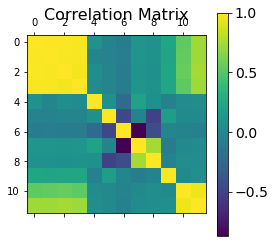

,high,low,open,close,volume,neg,neu,pos,compound,references,SMA_25,EMA_25
high,1.000000,0.985593,0.986487,0.984238,0.092597,-0.029959,-0.075820,0.102622,0.076752,0.226258,0.539622,0.731655
low,0.985593,1.000000,0.983708,0.985204,-0.011005,-0.041108,-0.071083,0.103499,0.086441,0.223827,0.548809,0.735428
open,0.986487,0.983708,1.000000,0.963870,0.058548,-0.020926,-0.074580,0.096136,0.071494,0.227045,0.562710,0.748365
close,0.984238,0.985204,0.963870,1.000000,0.028958,-0.021723,-0.083884,0.107155,0.084373,0.236551,0.533246,0.724513
volume,0.092597,-0.011005,0.058548,0.028958,1.000000,0.065550,-0.218356,0.210379,0.066967,-0.047580,0.033567,0.056264
neg,-0.029959,-0.041108,-0.020926,-0.021723,0.065550,1.000000,-0.469006,-0.029128,-0.498217,0.169528,0.017549,0.020175
neu,-0.075820,-0.071083,-0.074580,-0.083884,-0.218356,-0.469006,1.000000,-0.869159,-0.417242,-0.017013,-0.034847,-0.047988
pos,0.102622,0.103499,0.096136,0.107155,0.210379,-0.029128,-0.869159,1.000000,0.751203,-0.075738,0.028539,0.041716
compound,0.076752,0.086441,0.071494,0.084373,0.066967,-0.498217,-0.417242,0.751203,1.000000,-0.035572,0.045837,0.047691
references,0.226258,0.223827,0.227045,0.236551,-0.047580,0.169528,-0.017013,-0.075738,-0.035572,1.000000,0.016516,0.066979


In [21]:
plt.matshow(AMZN.corr())
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
plt.show()
AMZN.corr()

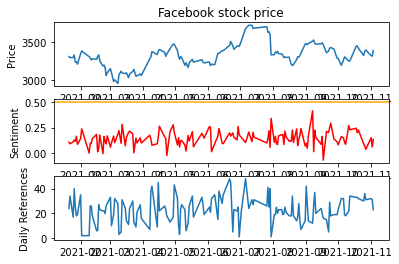

In [22]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(3)
# Plot RSI with the price
ax1.set_ylabel('Price')
ax1.plot(AMZN['close'])
ax2.set_ylabel('Sentiment')
ax2.plot(AMZN['compound'], color='red')
ax2.axhline(y=0.5, color='orange')
ax3.set_ylabel('Daily References')
ax3.plot(AMZN['references'])


plt.show()